# Testing audio

In [1]:
# Neuro
import mne
import mne_bids

# ML/Data
import numpy as np
import pandas as pd

# Tools
from pathlib import Path
import os
import spacy
import matplotlib.pyplot as plt
from functools import lru_cache


In [2]:
modality = "auditory"
decoding_criterion = 'wlength'
start = 'onset'
level = 'word'
subject = '2'
run_id = "01"

In [3]:
from utils import (
    match_list,
    add_syntax,
    mne_events,
    decoding_from_criterion,
    get_code_path,
    get_path,
)


# Testing using basic code

In [9]:
path = get_path(modality)
task_map = {"auditory": "listen", "visual": "read", "fmri": "listen"}
task = task_map[modality]
print(f"\n Epoching for run {run_id}, subject: {subject}\n")
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

raw.del_proj()  # To fix proj issues
raw.pick_types(meg=True, stim=False)
raw.load_data()

# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()




 Epoching for run 01, subject: 2

Opening raw data file /home/co/data/LPP_MEG_auditory/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 25000 ... 659999 =     25.000 ...   659.999 secs
Ready.
Reading events from /home/co/data/LPP_MEG_auditor

<ipython-input-9-43f27d9a7ab8>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-43f27d9a7ab8>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1647 events found
Event IDs: [  1 128]
Reading 0 ... 634999  =      0.000 ...   634.999 secs...


In [10]:
triggers = events

In [50]:
events = list()
for annot in raw.annotations:
    description = annot.pop("description")
    if "BAD_ACQ_SKIP" in description:
        continue
    event = eval(description)
    event["condition"] = "sentence"
    event["type"] = event.pop("kind").capitalize()
    event["start"] = annot["onset"]
    event["duration"] = annot["duration"]
    event["stop"] = annot["onset"] + annot["duration"]
    event["language"] = "french"
    events.append(event)

events_df = pd.DataFrame(events).rename(columns=dict(word="text"))
# remove empty words
events_df = events_df.loc[events_df.text != ""]

In [51]:
events_df = pd.DataFrame(events).rename(columns=dict(word="text"))
events_df

,text,condition,type,start,duration,stop,language
0,lorsque,sentence,Word,28.05,0.37,28.42,french
1,j,sentence,Word,28.42,0.02,28.44,french
2,avais,sentence,Word,28.53,0.23,28.76,french
3,six,sentence,Word,28.93,0.25,29.18,french
4,ans,sentence,Word,29.18,0.18,29.36,french
...,...,...,...,...,...,...,...
1627,peut,sentence,Word,634.51,0.14,634.65,french
1628,pas,sentence,Word,634.65,0.22,634.87,french
1629,aller,sentence,Word,634.87,0.17,635.04,french
1630,bien,sentence,Word,635.04,0.16,635.20,french


In [ ]:
events_df

In [52]:
words = events_df.loc[events_df.type == "Word"]
word_triggers = triggers[triggers[:, 2] > 1]

# Old version
# triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=0)  # type: ignore
# events_delta = np.round(np.diff(words.start.values), decimals=0)  # type: ignore
# i, j = match_list(triggers_delta, events_delta)

# New version
triggers_delta = np.diff(word_triggers[:, 0].astype(float) / raw.info["sfreq"])
events_delta = np.diff(words.start.values)
pres = 1e2
i, j = match_list(np.round(triggers_delta*pres), np.round(events_delta*pres))

assert len(i) / len(words) > 0.8
true_indices = words.iloc[j].index
events_df.loc[true_indices, "start"] = word_triggers[i, 0] / raw.info["sfreq"]

In [64]:
np.diff(word_triggers[:, 0])[:50]

array([ 370,  110,  401,  251,  220,  140,  320,  290,  351,  642,  460,
        611,  651,  320,  200,  270,  201,  100,  380,  480,  180,  131,
        690,  541, 1291,  310,  591,  130,  491,  611,  180,  461,  140,
       1171,  411,  130,  391,  151, 1671,   60,  412,  170,  150,  721,
        190,  480,  492,  550,  190,  520])

In [61]:
events_df.sort_values(by="start").text[:50]

37              du
38                
0          lorsque
1                j
2            avais
3              six
4              ans
5                j
6               ai
7               vu
8              une
9             fois
10             une
11      magnifique
12           image
13            dans
14              un
15           livre
16             sur
17              la
18           forêt
19          vierge
61          bouger
20             qui
21               s
22        appelait
23       histoires
24          vécues
25              ça
26    représentait
27              un
28         serpent
29             boa
30             qui
31         avalait
32              un
33           fauve
34           voilà
35              la
36           copie
39          dessin
40              on
41          disait
42            dans
43              le
44           livre
45             les
46        serpents
47            boas
48         avalent
Name: text, dtype: object

In [56]:
triggers_delta[:50]

array([0.37 , 0.11 , 0.401, 0.251, 0.22 , 0.14 , 0.32 , 0.29 , 0.351,
       0.642, 0.46 , 0.611, 0.651, 0.32 , 0.2  , 0.27 , 0.201, 0.1  ,
       0.38 , 0.48 , 0.18 , 0.131, 0.69 , 0.541, 1.291, 0.31 , 0.591,
       0.13 , 0.491, 0.611, 0.18 , 0.461, 0.14 , 1.171, 0.411, 0.13 ,
       0.391, 0.151, 1.671, 0.06 , 0.412, 0.17 , 0.15 , 0.721, 0.19 ,
       0.48 , 0.492, 0.55 , 0.19 , 0.52 ])

In [57]:
events_delta[:50]

array([0.37    , 0.11    , 0.4     , 0.25    , 0.22    , 0.14    ,
       0.319433, 0.290429, 0.350138, 0.64    , 0.46    , 0.61    ,
       0.65    , 0.32    , 0.2     , 0.27    , 0.2     , 0.1     ,
       0.38    , 0.48    , 0.18    , 0.13    , 0.69    , 0.54    ,
       1.29    , 0.31    , 0.59    , 0.13    , 0.49    , 0.61    ,
       0.18    , 0.46    , 0.14    , 1.17    , 0.41    , 0.13    ,
       0.39    , 0.075   , 0.075   , 1.67    , 0.06    , 0.41    ,
       0.17    , 0.15    , 0.72    , 0.19    , 0.48    , 0.49    ,
       0.55    , 0.19    ])

In [49]:
triggers[i,0]/ raw.info["sfreq"]

array([ 42.046,  45.318,  45.688, ..., 652.803, 652.943, 653.163])

In [35]:
i

array([   0,    1,    2, ..., 1641, 1642, 1643])

In [36]:
j

array([   0,    1,    2, ..., 1628, 1629, 1630])

In [21]:
true_indices

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629],
           dtype='int64', length=1546)

In [47]:
words.iloc[j]

,text,condition,type,start,duration,stop,language
0,lorsque,sentence,Word,28.05,0.37,28.42,french
1,j,sentence,Word,28.42,0.02,28.44,french
2,avais,sentence,Word,28.53,0.23,28.76,french
3,six,sentence,Word,28.93,0.25,29.18,french
4,ans,sentence,Word,29.18,0.18,29.36,french
...,...,...,...,...,...,...,...
1626,ne,sentence,Word,634.40,0.11,634.51,french
1627,peut,sentence,Word,634.51,0.14,634.65,french
1628,pas,sentence,Word,634.65,0.22,634.87,french
1629,aller,sentence,Word,634.87,0.17,635.04,french


In [18]:
events_delta

array([  3.272,   0.37 ,   0.11 , ...,   0.14 ,   0.22 , -17.963])

In [37]:
events_df

,text,condition,type,start,duration,stop,language
0,lorsque,sentence,Word,42.046,0.37,28.42,french
1,j,sentence,Word,45.318,0.02,28.44,french
2,avais,sentence,Word,45.688,0.23,28.76,french
3,six,sentence,Word,45.798,0.25,29.18,french
4,ans,sentence,Word,46.199,0.18,29.36,french
...,...,...,...,...,...,...,...
1627,peut,sentence,Word,652.693,0.14,634.65,french
1628,pas,sentence,Word,652.803,0.22,634.87,french
1629,aller,sentence,Word,652.943,0.17,635.04,french
1630,bien,sentence,Word,653.163,0.16,635.20,french


In [14]:
raw.first_samp

25000

In [8]:
# read events
meta = pd.read_csv(event_file, sep="\t")
meta['word'] = [eval(w)['word'] for w in meta.trial_type]


# Events / triggers matching

In [21]:
# word events
# match events and metadata
word_events = events[events[:, 2] > 1]
meg_delta = np.diff(word_events[:, 0].astype(float) / raw.info["sfreq"])
meta_delta = np.diff(meta.onset.values)

pres = 1e2
i, j = match_list(np.round(meg_delta*pres), np.round(meta_delta*pres))
assert len(i) / len(meg_delta) > .85
assert len(i) > 500
meta = meta.iloc[j].reset_index(drop=True)
meta["start"] = word_events[i, 0] / raw.info["sfreq"]

In [13]:
# # STephane
# word_events = events[events[:, 2] > 1]

# triggers_delta = np.round(np.diff(word_events[:, 0] / raw.info["sfreq"]), decimals=0)  # type: ignore
# events_delta = np.round(np.diff(meta.onset.values), decimals=0)  # type: ignore
# i, j = match_list(triggers_delta, events_delta)

# meta["start"] = word_events[i, 0] / raw.info["sfreq"]

# meta["has_trigger"] = False
# meta.loc[j, "has_trigger"] = True

# # integrate events to meta for simplicity
# meta.loc[j, "start"] = events[i, 0] / raw.info["sfreq"]

ValueError: Length of values (1599) does not match length of index (1632)

In [18]:
# word events
# # match events and metadata
# word_events = events[events[:, 2] > 1]
# meg_delta = np.diff(word_events[:, 0].astype(float) / raw.info["sfreq"])
# meta_delta = np.diff(meta.onset.values)

# pres = 1e2
# i, j = match_list(np.round(meg_delta*pres), np.round(meta_delta*pres))
# assert len(i) / len(meg_delta) > .85
# assert len(i) > 500
# # meta = meta.iloc[j].reset_index(drop=True)
# # meta["start"] = word_events[i, 0] / raw.info["sfreq"]

# meta["start"] = 0

# meta["has_trigger"] = False
# meta.loc[j, "has_trigger"] = True

# # integrate events to meta for simplicity
# meta.loc[j, "start"] = events[i, 0] / raw.info["sfreq"]



In [22]:
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    events[:, 0] = meta.start*raw.info['sfreq']
    return dict(events=events, metadata=meta.reset_index())

In [23]:
raw.filter(.5, 20., n_jobs=-1)


epochs = mne.Epochs(raw, **mne_events(meta), decim=10, tmin=-.2, tmax=.8)
epochs 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    6.4s


Adding metadata with 8 columns
1511 matching events found


[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    6.7s finished


Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Number of events,1511
Events,1: 1511
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [26]:
epochs.load_data()

Using data from preloaded Raw for 1511 events and 1001 original time points (prior to decimation) ...
0 bad epochs dropped


Number of events,1511
Events,1: 1511
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [27]:

from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from wordfreq import zipf_frequency


def decod(epochs, target):
    model = make_pipeline(StandardScaler(), RidgeCV())
    cv = KFold(n_splits=5)
    y = epochs.metadata[target].values
    r = np.zeros(len(epochs.times))
    for t in trange(len(epochs.times)):
        X = epochs.get_data()[:, :, t]
        for train, test in cv.split(X, y):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            r[t] += pearsonr(y_pred, y[test])[0]
    r /= cv.n_splits
    return r


In [28]:
epochs.metadata['wfreq'] = epochs.metadata.word.apply(lambda w: zipf_frequency(w, 'fr')).values

  0%|          | 0/101 [00:00<?, ?it/s]

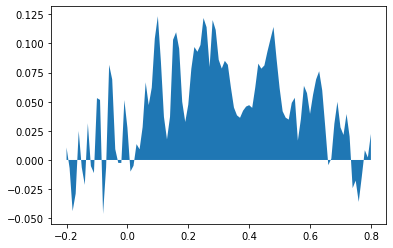

In [29]:
import matplotlib.pyplot as plt
r = decod(epochs, 'wfreq')
plt.fill_between(epochs.times, r)

  0%|          | 0/101 [00:00<?, ?it/s]

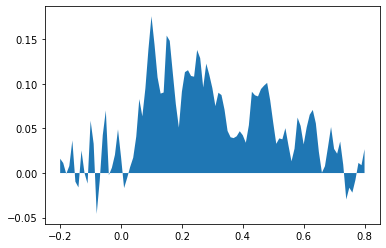

In [48]:
import matplotlib.pyplot as plt
plt.fill_between(epochs.times, r)
r = decod(epochs, 'wfreq')

## seems to work!

# Now testing with code integration

In [56]:
from dataset import populate_metadata_epochs

In [57]:
modality = "auditory"
decoding_criterion = 'wlength'
start = 'onset'
level = 'word'
subject = '2'
run_id = "01"
runs = 1



In [58]:
epochs = populate_metadata_epochs(
    modality,
    subject,
    level,
    start,
    runs,
    decoding_criterion
)


 Epoching for run 1, subject: 2



In [59]:
epochs.metadata['wfreq'] = epochs.metadata.word.apply(lambda w: zipf_frequency(w, 'fr')).values

In [63]:
epochs

Number of events,1511
Events,1: 1511
Time range,-0.300 – 1.000 sec
Baseline,off


  0%|          | 0/131 [00:00<?, ?it/s]

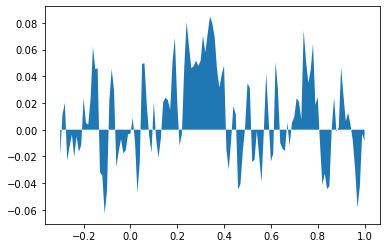

In [60]:
import matplotlib.pyplot as plt
r = decod(epochs, 'wfreq')
plt.fill_between(epochs.times, r)

In [62]:
epochs.metadata

,index,Unnamed: 0,onset,duration,trial_type,word,wlength,run,n_closing,is_last_word,...,sentence_start,sentence_stop,sentence_words,constituent_id,const_word_id,constituent_length,constituent_start,constituent_stop,constituent_words,wfreq
0,1,1,3.42,0.02,"{'kind': 'word', 'word': 'j'}",j,1,1,1,False,...,42.046,53.527,NaN,0,1.0,3.0,42.046,45.918000,NaN,6.65
1,2,2,3.53,0.23,"{'kind': 'word', 'word': 'avais'}",avais,5,1,2,False,...,42.046,53.527,NaN,0,2.0,3.0,42.046,45.918000,NaN,5.53
2,3,3,3.93,0.25,"{'kind': 'word', 'word': 'six'}",six,3,1,1,False,...,42.046,53.527,NaN,1,0.0,2.0,45.798,46.379000,"[six, ans]",5.15
3,4,4,4.18,0.18,"{'kind': 'word', 'word': 'ans'}",ans,3,1,4,False,...,42.046,53.527,NaN,1,1.0,2.0,45.798,46.379000,NaN,6.00
4,5,5,4.40,0.14,"{'kind': 'word', 'word': 'j'}",j,1,1,1,False,...,42.046,53.527,NaN,2,0.0,3.0,46.450,47.100429,"[j, ai, vu]",6.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,1626,1626,609.40,0.11,"{'kind': 'word', 'word': 'ne'}",ne,2,1,1,False,...,650.238,653.343,NaN,490,1.0,3.0,652.121,652.833000,NaN,6.69
1627,1627,1627,609.51,0.14,"{'kind': 'word', 'word': 'peut'}",peut,4,1,2,False,...,650.238,653.343,NaN,490,2.0,3.0,652.121,652.833000,NaN,6.19
1628,1628,1628,609.65,0.22,"{'kind': 'word', 'word': 'pas'}",pas,3,1,1,False,...,650.238,653.343,NaN,491,0.0,2.0,652.803,653.113000,"[pas, aller]",7.00
1629,1629,1629,609.87,0.17,"{'kind': 'word', 'word': 'aller'}",aller,5,1,2,False,...,650.238,653.343,NaN,491,1.0,2.0,652.803,653.113000,NaN,5.61


In [61]:
meta

,Unnamed: 0,onset,duration,trial_type,word,start
0,0,3.05,0.37,"{'kind': 'word', 'word': 'lorsque'}",lorsque,45.318
1,1,3.42,0.02,"{'kind': 'word', 'word': 'j'}",j,45.688
2,2,3.53,0.23,"{'kind': 'word', 'word': 'avais'}",avais,45.798
3,3,3.93,0.25,"{'kind': 'word', 'word': 'six'}",six,46.199
4,4,4.18,0.18,"{'kind': 'word', 'word': 'ans'}",ans,46.450
...,...,...,...,...,...,...
1430,1625,609.20,0.20,"{'kind': 'word', 'word': 'on'}",on,652.492
1431,1626,609.40,0.11,"{'kind': 'word', 'word': 'ne'}",ne,652.693
1432,1627,609.51,0.14,"{'kind': 'word', 'word': 'peut'}",peut,652.803
1433,1628,609.65,0.22,"{'kind': 'word', 'word': 'pas'}",pas,652.943


In [13]:
evo = epochs.average(method='median')

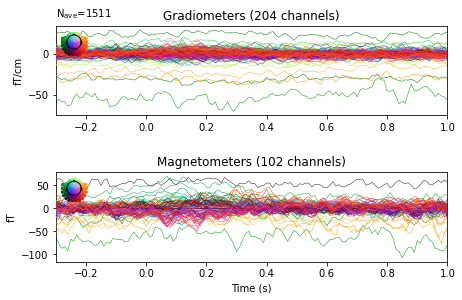

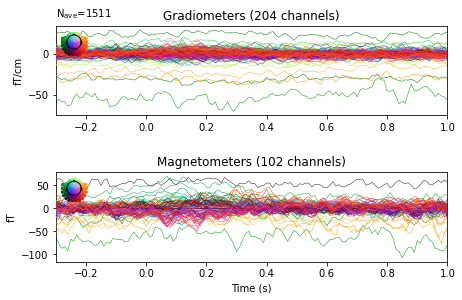

In [14]:
evo.plot(spatial_colors=True)

In [22]:
epochs

Number of events,4813
Events,1: 4813
Time range,-0.300 – 1.000 sec
Baseline,off


In [9]:
# match events and metadata
word_events = events[events[:, 2]==128]
meg_delta = np.round(np.diff(word_events[:, 0]/raw.info['sfreq']))
meta_delta = np.round(np.diff(meta.onset.values))
i, j = match_list(meg_delta, meta_delta)
assert len(i) > 1000
events = events[i]
meta = meta.iloc[j].reset_index()

epochs = mne.Epochs(raw, events, metadata=meta, tmin=-.3, tmax=.8, decim=10)

Adding metadata with 5 columns
1599 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


<ipython-input-9-cd04c69a72ca>:10: RuntimeWarning: The measurement information indicates a low-pass frequency of 330.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, metadata=meta, tmin=-.3, tmax=.8, decim=10)


In [5]:
epochs.metadata.head(10)

,index,Unnamed: 0,onset,duration,trial_type,word,wlength,run,n_closing,is_last_word,...,sentence_length,sentence_start,sentence_stop,sentence_words,constituent_id,const_word_id,constituent_length,constituent_start,constituent_stop,constituent_words
0,1,1,3.420000,0.020000,"{'kind': 'word', 'word': 'j'}",j,1,1,1,False,...,25.0,42.046,53.527,NaN,0,1.0,3.0,42.046,45.918000,NaN
1,2,2,3.530000,0.230000,"{'kind': 'word', 'word': 'avais'}",avais,5,1,2,False,...,25.0,42.046,53.527,NaN,0,2.0,3.0,42.046,45.918000,NaN
2,3,3,3.930000,0.250000,"{'kind': 'word', 'word': 'six'}",six,3,1,1,False,...,25.0,42.046,53.527,NaN,1,0.0,2.0,45.798,46.379000,"[six, ans]"
3,4,4,4.180000,0.180000,"{'kind': 'word', 'word': 'ans'}",ans,3,1,4,False,...,25.0,42.046,53.527,NaN,1,1.0,2.0,45.798,46.379000,NaN
4,5,5,4.400000,0.140000,"{'kind': 'word', 'word': 'j'}",j,1,1,1,False,...,25.0,42.046,53.527,NaN,2,0.0,3.0,46.450,47.100429,"[j, ai, vu]"
5,6,6,4.540000,0.234013,"{'kind': 'word', 'word': 'ai'}",ai,2,1,1,False,...,25.0,42.046,53.527,NaN,2,1.0,3.0,46.450,47.100429,NaN
6,7,7,4.859433,0.290429,"{'kind': 'word', 'word': 'vu'}",vu,2,1,2,False,...,25.0,42.046,53.527,NaN,2,2.0,3.0,46.450,47.100429,NaN
7,8,8,5.149862,0.350138,"{'kind': 'word', 'word': 'une'}",une,3,1,1,False,...,25.0,42.046,53.527,NaN,3,0.0,2.0,47.130,47.750000,"[une, fois]"
8,9,9,5.500000,0.330000,"{'kind': 'word', 'word': 'fois'}",fois,4,1,2,False,...,25.0,42.046,53.527,NaN,3,1.0,2.0,47.130,47.750000,NaN
9,10,10,6.140000,0.460000,"{'kind': 'word', 'word': 'une'}",une,3,1,1,False,...,25.0,42.046,53.527,NaN,4,0.0,3.0,47.771,49.373000,"[une, magnifique, image]"


In [2]:
all_scores = decoding_from_criterion(decoding_criterion, epochs, level, subject)


Decoding word length for: word
...................................................................................................................................

Text(0.5, 0.98, 'Decoding Performance for wlength and auditory for sub-2, epoched on word onset')

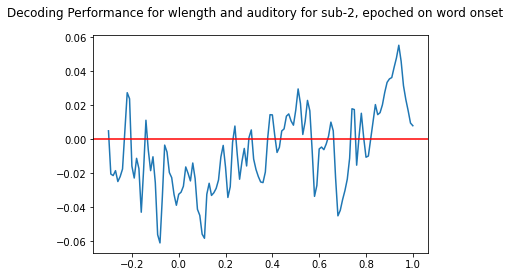

In [3]:
import pandas as pd
data = pd.DataFrame(all_scores)
y = []
x = []
for s, t in data.groupby("t"):
    score_avg = t.score.mean()
    y.append(score_avg)
    x.append(s)

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.axhline(y=0, color="r", linestyle="-")
plt.suptitle(
f"Decoding Performance for {decoding_criterion} and {modality} for sub-{subject}, epoched on {level} {start}"
)

In [1]:
from dataset import read_raw, populate_metadata_epochs, decoding_from_criterion

modality = "visual"
decoding_criterion = 'embeddings'
start = 'onset'
level = 'word'
subject = '5'

/home/co/miniconda3/envs/meg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
epochs = populate_metadata_epochs(modality, subject, level, start, runs=3, decoding_criterion=decoding_criterion)


 Epoching for run 1, subject: 5


 Epoching for run 2, subject: 5


 Epoching for run 3, subject: 5



In [3]:
all_scores = decoding_from_criterion(decoding_criterion, epochs, level, subject)


Word embeddings decoding
For: word
...................................................................................................................................

Text(0.5, 0.98, 'Decoding Performance for embeddings and visual for sub-5, epoched on word onset')

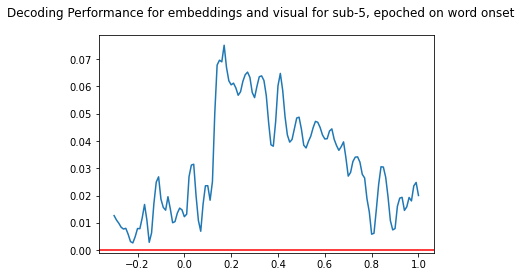

In [5]:
import pandas as pd
data = pd.DataFrame(all_scores)
y = []
x = []
for s, t in data.groupby("t"):
    score_avg = t.score.mean()
    y.append(score_avg)
    x.append(s)

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.axhline(y=0, color="r", linestyle="-")
plt.suptitle(
f"Decoding Performance for {decoding_criterion} and {modality} for sub-{subject}, epoched on {level} {start}"
)

In [7]:
data

,subject,score,t
0,5,0.012652,-0.30
1,5,0.011062,-0.29
2,5,0.009865,-0.28
3,5,0.008395,-0.27
4,5,0.007737,-0.26
...,...,...,...
126,5,0.019300,0.96
127,5,0.018036,0.97
128,5,0.023537,0.98
129,5,0.024821,0.99


In [ ]:
decoding_criterion = 'embeddings'
all_scores = decoding_from_criterion(decoding_criterion, epochs, level, subject)

In [8]:
import mne

report = mne.Report()

for subject in range(3,7):
    epochs = populate_metadata_epochs(modality, str(subject), level, start, runs=3, decoding_criterion=decoding_criterion)
    evo = epochs.average(method="median")
    report.add_evokeds(evo)
    report.save("report_evoked.html", overwrite=True)



 Epoching for run 1, subject: 5


 Epoching for run 1, subject: 6

